In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

# My Python Modules
import FFIndustry as ffi
import FYP_fns as fyp
import importlib
importlib.reload(ffi)
importlib.reload(fyp)

import warnings
warnings.filterwarnings("ignore")

from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
import statsmodels.formula.api as smf
from scipy.stats import kurtosis
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Descriptive Statistics

In [5]:
# call regression sample data
reg_df = pd.read_parquet('Generated Data/CleanCode_reg_df_des.parquet')
print('unbalanced reg data:', reg_df['gvkey'].nunique(), reg_df.shape)

robust_raw = pd.read_parquet('Generated Data/CleanCode_robust_raw_des.parquet')
print('robust data:', robust_raw['gvkey'].nunique(), robust_raw.shape)

reg_df_bal = pd.read_parquet('Generated Data/CleanCode_reg_df_bal_des.parquet')
print('balanced reg data:', reg_df_bal['gvkey'].nunique(), reg_df_bal.shape)

unbalanced reg data: 3416 (32908, 48)
robust data: 6383 (126514, 48)
balanced reg data: 1641 (21333, 48)


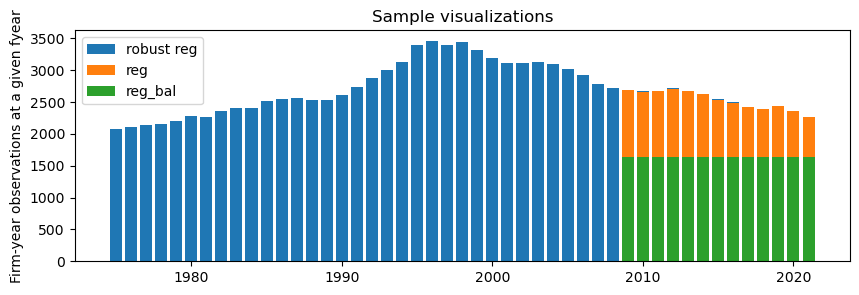

In [6]:
# visualize three regression data samples

plt.figure(figsize=(10,3))
### robust raw: unbalanced data sample from 1975-2021
# this sample is used to compare robustness of main regression results with reduced survivorship bias
plt.bar(robust_raw['fyear'].value_counts().index,
        robust_raw['fyear'].value_counts(), label='robust reg');
### reg: unbalanced data sample from 2009-2021
# our main regression sample used for the analysis
plt.bar(reg_df['fyear'].value_counts().index,
        reg_df['fyear'].value_counts(), label='reg');
### reg bal: balanced data sample from 2009-2021
# this sample is used to compare robustness of main regression results with stronger survivorship bias
# this sample is also strongly balanced for examining regression results with more clear effects
plt.bar(reg_df_bal['fyear'].value_counts().index,
        reg_df_bal['fyear'].value_counts(), label='reg_bal');
plt.title('Sample visualizations')
plt.ylabel('Firm-year observations at a given fyear')
plt.legend();

# Median, mean ages decrease with longer period datasets
longer period dataset includes firms that died out in the past

In [7]:
age_des = pd.concat([reg_df_bal['age'].describe(), reg_df['age'].describe(), robust_raw['age'].describe()] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1).T
age_des.round(0)
#age_des.to_excel('threesample_stat.xlsx')
age_des

count       mean        std  min   25%   50%   75%  \
2009-2021 Balanced     21333.0  34.739090  17.978407  1.0  19.0  31.0  49.0   
2009-2021 Unbalanced   32908.0  30.553118  19.116752  1.0  15.0  26.0  47.0   
1975-2021 Unbalanced  126514.0  23.407654  15.468829  1.0  11.0  21.0  34.0   

                       max  
2009-2021 Balanced    76.0  
2009-2021 Unbalanced  76.0  
1975-2021 Unbalanced  76.0

In [8]:
asset_des = pd.concat([reg_df_bal['log_asset'].describe(), reg_df['log_asset'].describe(), robust_raw['log_asset'].describe()] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1).T
asset_des.round(0)
asset_des

count      mean       std       min       25%  \
2009-2021 Balanced     21333.0  7.289445  2.254217 -0.765718  5.782581   
2009-2021 Unbalanced   32908.0  6.864409  2.263681 -2.198225  5.311907   
1975-2021 Unbalanced  126514.0  5.780956  2.285723 -4.074542  4.122993   

                           50%       75%        max  
2009-2021 Balanced    7.377301  8.879189  13.569377  
2009-2021 Unbalanced  6.926064  8.432667  13.569377  
1975-2021 Unbalanced  5.684688  7.378421  13.589574

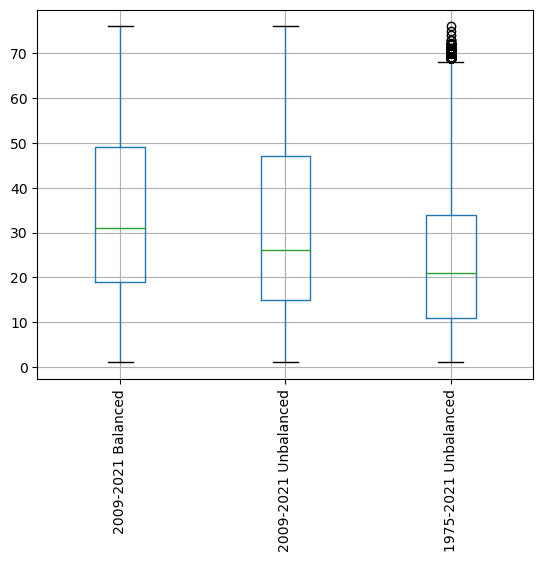

In [9]:
age_df = pd.concat([reg_df_bal['age'], reg_df['age'], robust_raw['age']] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1)
age_df.boxplot()
plt.xticks(list(range(1,len(age_df.columns)+1)), list(age_df.columns), rotation=90);

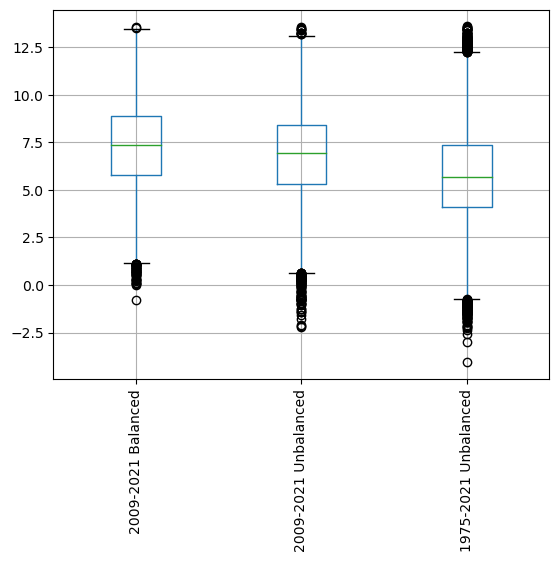

In [10]:
asset_des = pd.concat([reg_df_bal['log_asset'], reg_df['log_asset'], robust_raw['log_asset']] , axis=1) \
.set_axis(['2009-2021 Balanced','2009-2021 Unbalanced','1975-2021 Unbalanced'], axis=1)
asset_des.boxplot()
plt.xticks(list(range(1,len(age_df.columns)+1)), list(age_df.columns), rotation=90);

# Variables used in Regression

**Dependent Variables**
1. Book Leverage ($LEV_{𝑖,𝑡}$, LEV_TD) $= \frac{ShortTermDebt_{𝑖,𝑡} + LongTermDebt_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

2. Market Leverage ($MktLEV_{𝑖,𝑡}$, Mkt_LEV) $= \frac{ShortTermDebt_{𝑖,𝑡} + LongTermDebt_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡} - BookCommonEquity_{𝑖,𝑡} - MarketCommonEquity_{𝑖,𝑡}} $ 

**Key Independent Variables**
1. Intangibility ($INT_{𝑖,𝑡}$, intan_cap_AT) $= \frac{BookIntangibles_{𝑖,𝑡} + KnowledgeCapital_{𝑖,𝑡} + OrganizationCapital_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}}$ $= \frac{PTIntangibles_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}}$

2. Tangibility ($TAN_{𝑖,𝑡}$, PPENT_AT) $= \frac{NetPPE_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

3. Knowledge Capital/TA ($KnowCap_{𝑖,𝑡}$, know_cap_AT) $= \frac{KnowledgeCapital_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

4. Organization Capital/TA ($OrganCap_{𝑖,𝑡}$, organ_cap_AT) $= \frac{OrganizationCapital_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

5. Book Intangibility ($BVINT_{𝑖,𝑡}$, intan_AT) $= \frac{BookIntangibles_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

6. Book Intangibility Less Goodwill ($BVINT_{𝑖,𝑡}$, intan_lessgdwl_AT) $= \frac{BookIntangibles_{𝑖,𝑡} - Goodwill_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

**Control Variables**
1. Firm Size ($lnAsset_{𝑖,𝑡}$, log_asset) $= {ln(TotalAssets_{𝑖,𝑡})}$

2. Firm Age ($Age_{𝑖,𝑡}$, log_asset)

3. Market to Book ($MtB_{𝑖,𝑡}$, Market_to_Book) $= \frac{MarketCapitalization_{𝑖,𝑡}}{BookCommonEquity_{𝑖,𝑡}} $

4. Operating Profitability ($Opprofit_{𝑖,𝑡}$, Op_profit) $= \frac{MarketCapitalization_{𝑖,𝑡}}{BookCommonEquity_{𝑖,𝑡}} $

5. Cash Liquidity ($Cashliq_{𝑖,𝑡}$, Cash_liq) $= \frac{Cash_{𝑖,𝑡} + ShortTermInvestments_{𝑖,𝑡}}{TotalAssets_{𝑖,𝑡}} $

2. Marginal Tax Rates ($MTR_{𝑖,𝑡}$, MTR_AI)

In [4]:
# variables for descriptive analysis
# Level data (Book Values) for descriptive analysis
des_BVs = ['age', 'at', 'sale', 'T_Debt','gdwl', 'ppent',
           'intan_cap', 'intan_cap_lessgdwl',
           'knowledge_cap', 'organization_cap',
           'intan', 'intan_lessgdwl']

# Ratio data and log scaled data for descriptive analysis
des_ratios = ['log_asset', 'log_sale',
              'LEV_TD', 'Mkt_LEV', 
              'Market_to_Book', 'Op_profit', 'Cash_liq','MTR_BI', 'MTR_AI',
              'PPENT_AT', 'intan_cap_AT', 'intan_cap_lessgdwl_AT', 
              'intan_AT', 'intan_lessgdwl_AT', 
              'know_cap_AT', 'organ_cap_AT'] # 'Altman_Z',

# potential variables to be winsorized
winsor_cols = ['LEV_TD', 'Mkt_LEV',
               'PPENT_AT', 'intan_cap_AT', 
               'know_cap_AT', 'organ_cap_AT', 'intan_AT', 'intan_lessgdwl_AT',
               'log_asset', 'Market_to_Book', 'Op_profit', 'Cash_liq']

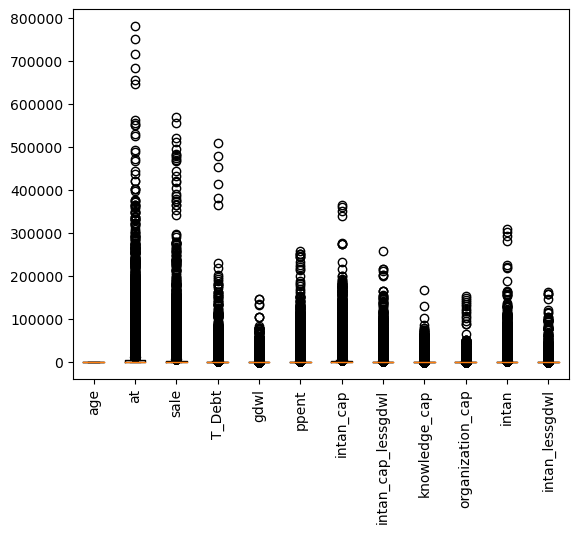

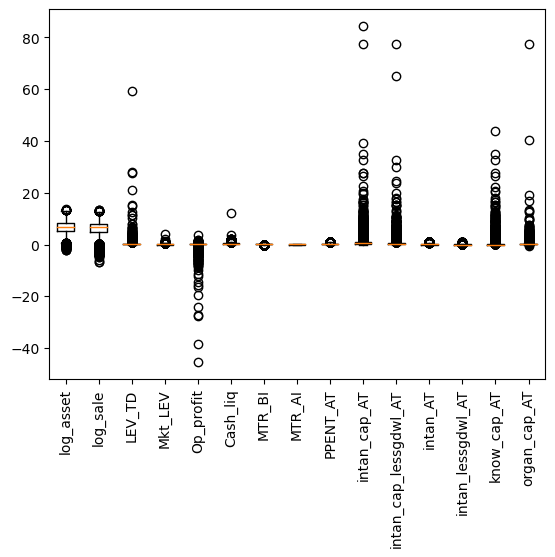

In [5]:
# Many Outliers in the regression variables
df = reg_df[des_BVs].copy()
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);
plt.show()

df = reg_df[des_ratios].drop(columns=['Market_to_Book']) # des_BVs des_ratios
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

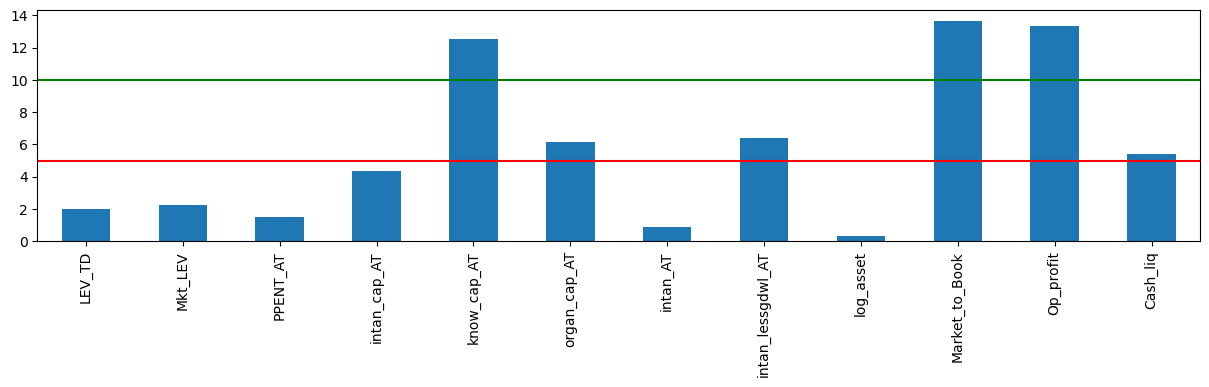

In [6]:
# visualize % of outliers in reg_df
plt.figure(figsize=(15,3))
fyp.vis_outliers(reg_df[winsor_cols])
plt.axhline(5,color='red')
plt.axhline(10,color='green');

before: [2009. 2010. 2011. 2012. 2013. 2014. 2015.]
after: [2016. 2017. 2018. 2019. 2020. 2021.]


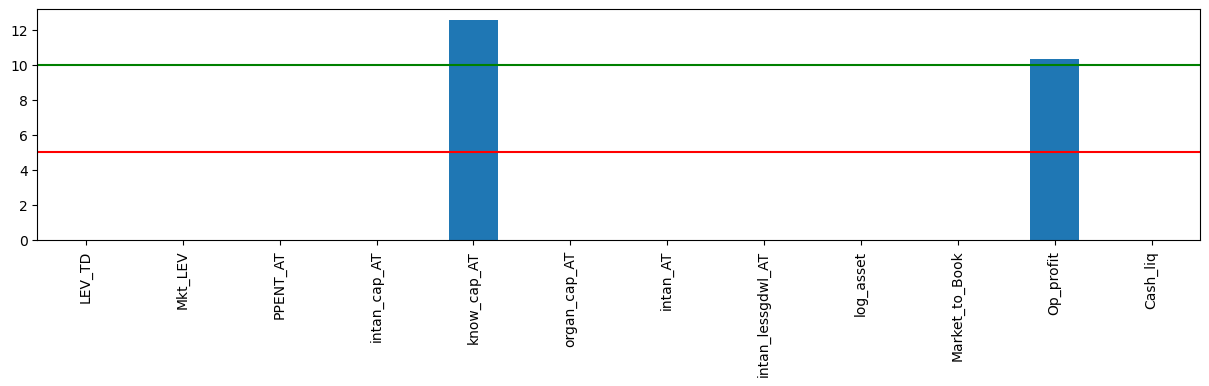

In [7]:
# winsorize regression variables
winsor_more = ['know_cap_AT', 'organ_cap_AT', 'intan_lessgdwl_AT',
               'Market_to_Book', 'Op_profit', 'Cash_liq'] 

winsor_less = ['LEV_TD', 'Mkt_LEV', 
               'intan_cap_AT', 'PPENT_AT', 'intan_AT',
               'log_asset']

importlib.reload(fyp)
reg_df_w = fyp.get_winsor_df(reg_df, winsor_less, winsor_more, pct1=0.05, pct2=0.1)
reg_df_bal_w = fyp.get_winsor_df(reg_df_bal, winsor_less, winsor_more, pct1=0.05, pct2=0.1)
robust_raw_w = fyp.get_winsor_df(robust_raw, winsor_less, winsor_more, pct1=0.05, pct2=0.1)


### Setting Dataset for EDA 
# start with the winsorized dataset
des_df = reg_df_w.copy()
# divide firms with tangibility above their industry median tangibility: high tangibility=1, 0 otherwise
des_df = fyp.Tangibility_dummy(des_df, visualize=False)
# divide the fyears into two periods: After 2015 = 1, 0 otherwise
des_df = fyp.Time_period_dummy(des_df, T=2015)

# Check
print('before:', des_df[des_df['After2015'] == 0]['fyear'].unique())
print('after:', des_df[des_df['After2015'] == 1]['fyear'].unique())
# create interaction terms between high tangibility and After 2015 dummy variables
des_df = fyp.heterogeneity_vars(des_df)

industry_dummies = list(des_df['sic'].unique())
industry_dummies.remove('Other') # base dummy variable for industry to be omitted to avoid dummy trap
columns = ['gvkey','sic','fyear','High_Tan','After2015'] + industry_dummies
for cat_var in columns:
    des_df[cat_var] = pd.Categorical(des_df[cat_var])

## Visualize % of outliers after winsorization
plt.figure(figsize=(15,3))
fyp.vis_outliers(des_df[winsor_cols])
plt.axhline(5,color='red')
plt.axhline(10,color='green');

In [8]:
reg_vars = ['LEV_TD', 'Mkt_LEV',
            'PPENT_AT', 'intan_cap_AT', 
            'know_cap_AT', 'organ_cap_AT', 'intan_AT', 'intan_lessgdwl_AT',
            'age', 'log_asset', 'Market_to_Book', 'Op_profit', 'Cash_liq', 'MTR_AI']

sum_table_BV = reg_df_w[reg_vars].describe().T.round(3).iloc[:,1:]
#sum_table_BV.to_excel('sum_table_BV.xlsx')

# Summary of Descriptive Statistics
sum_table_BV

mean     std    min     25%     50%     75%     max
LEV_TD              0.243   0.203  0.000   0.049   0.222   0.381   0.672
Mkt_LEV             0.159   0.150  0.000   0.021   0.123   0.253   0.498
PPENT_AT            0.265   0.243  0.017   0.074   0.171   0.401   0.806
intan_cap_AT        0.590   0.426  0.018   0.234   0.552   0.838   1.614
know_cap_AT         0.113   0.169  0.000   0.000   0.010   0.162   0.502
organ_cap_AT        0.213   0.187  0.000   0.059   0.161   0.332   0.580
intan_AT            0.192   0.202  0.000   0.014   0.119   0.327   0.637
intan_lessgdwl_AT   0.060   0.070  0.000   0.001   0.029   0.102   0.203
age                30.553  19.117  1.000  15.000  26.000  47.000  76.000
log_asset           6.871   2.101  3.101   5.312   6.926   8.433  10.609
Market_to_Book      2.876   2.223  0.538   1.201   2.120   3.868   7.695
Op_profit           0.086   0.097 -0.119   0.047   0.102   0.153   0.216
Cash_liq            0.317   0.283  0.022   0.077   0.223   0.494   0.880
MTR_AI              0.143   0.112  0.000   0.028   0.143   0.210   0.392

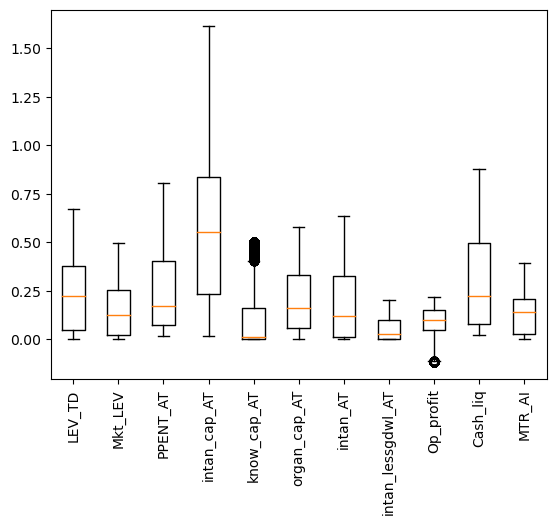

In [9]:
df = reg_df_w[reg_vars].copy().drop(columns=['age','log_asset','Market_to_Book'])
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=90);

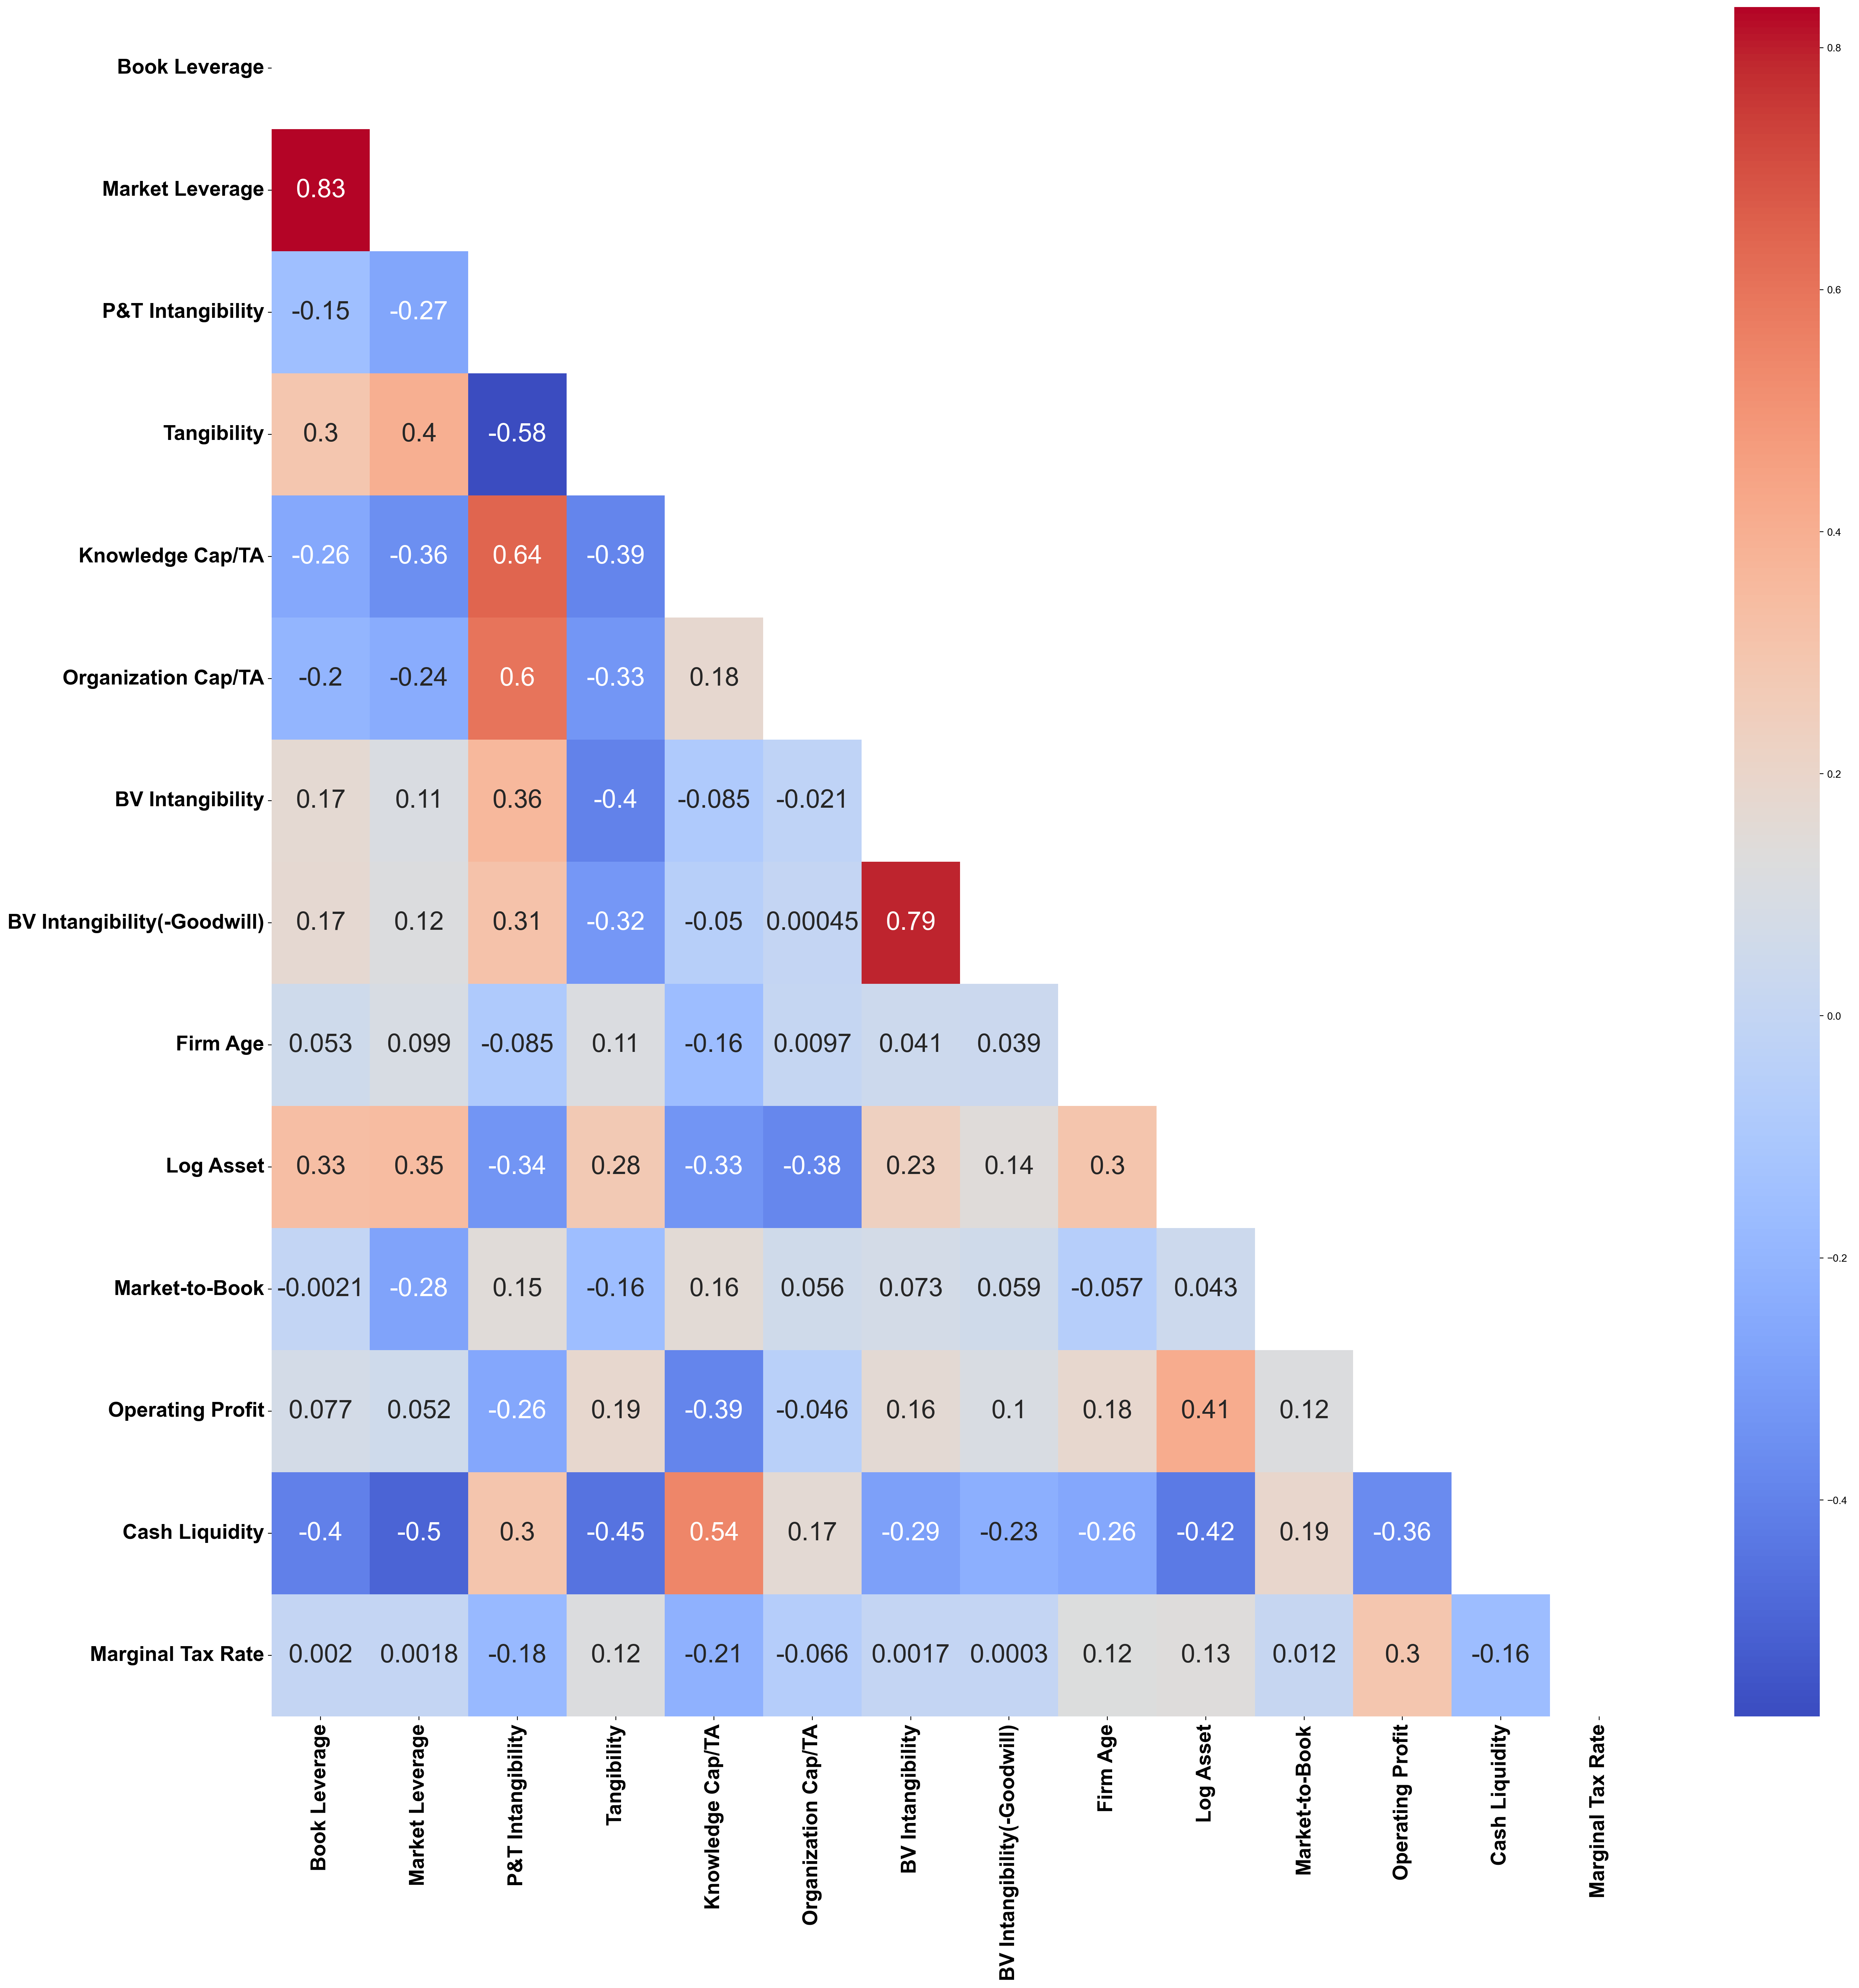

In [10]:
import seaborn as sns

all_cols = ['LEV_TD', 'Mkt_LEV',
            'intan_cap_AT', 'PPENT_AT',
            'know_cap_AT', 'organ_cap_AT',
            'intan_AT', 'intan_lessgdwl_AT',
            'age', 'log_asset', 'Market_to_Book', 'Op_profit',
            'Cash_liq', 'MTR_AI']
rename_cols = ['Book Leverage', 'Market Leverage',
            'P&T Intangibility', 'Tangibility',
            'Knowledge Cap/TA', 'Organization Cap/TA',
            'BV Intangibility', 'BV Intangibility(-Goodwill)',
            'Firm Age', 'Log Asset', 'Market-to-Book', 'Operating Profit',
            'Cash Liquidity', 'Marginal Tax Rate']

# Multicollinearity check
fig, ax = plt.subplots(figsize=(30, 30), dpi=200)
corr_matrix = reg_df_w[all_cols].set_axis(rename_cols, axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, annot_kws={"size": 25});
ax.set_xticklabels(rename_cols, rotation=90, fontsize = 20, fontweight='bold');
ax.set_yticklabels(rename_cols, rotation=0, fontsize = 20, fontweight='bold');
sns.set(font_scale=2)
#plt.savefig('corr_matrix.png')

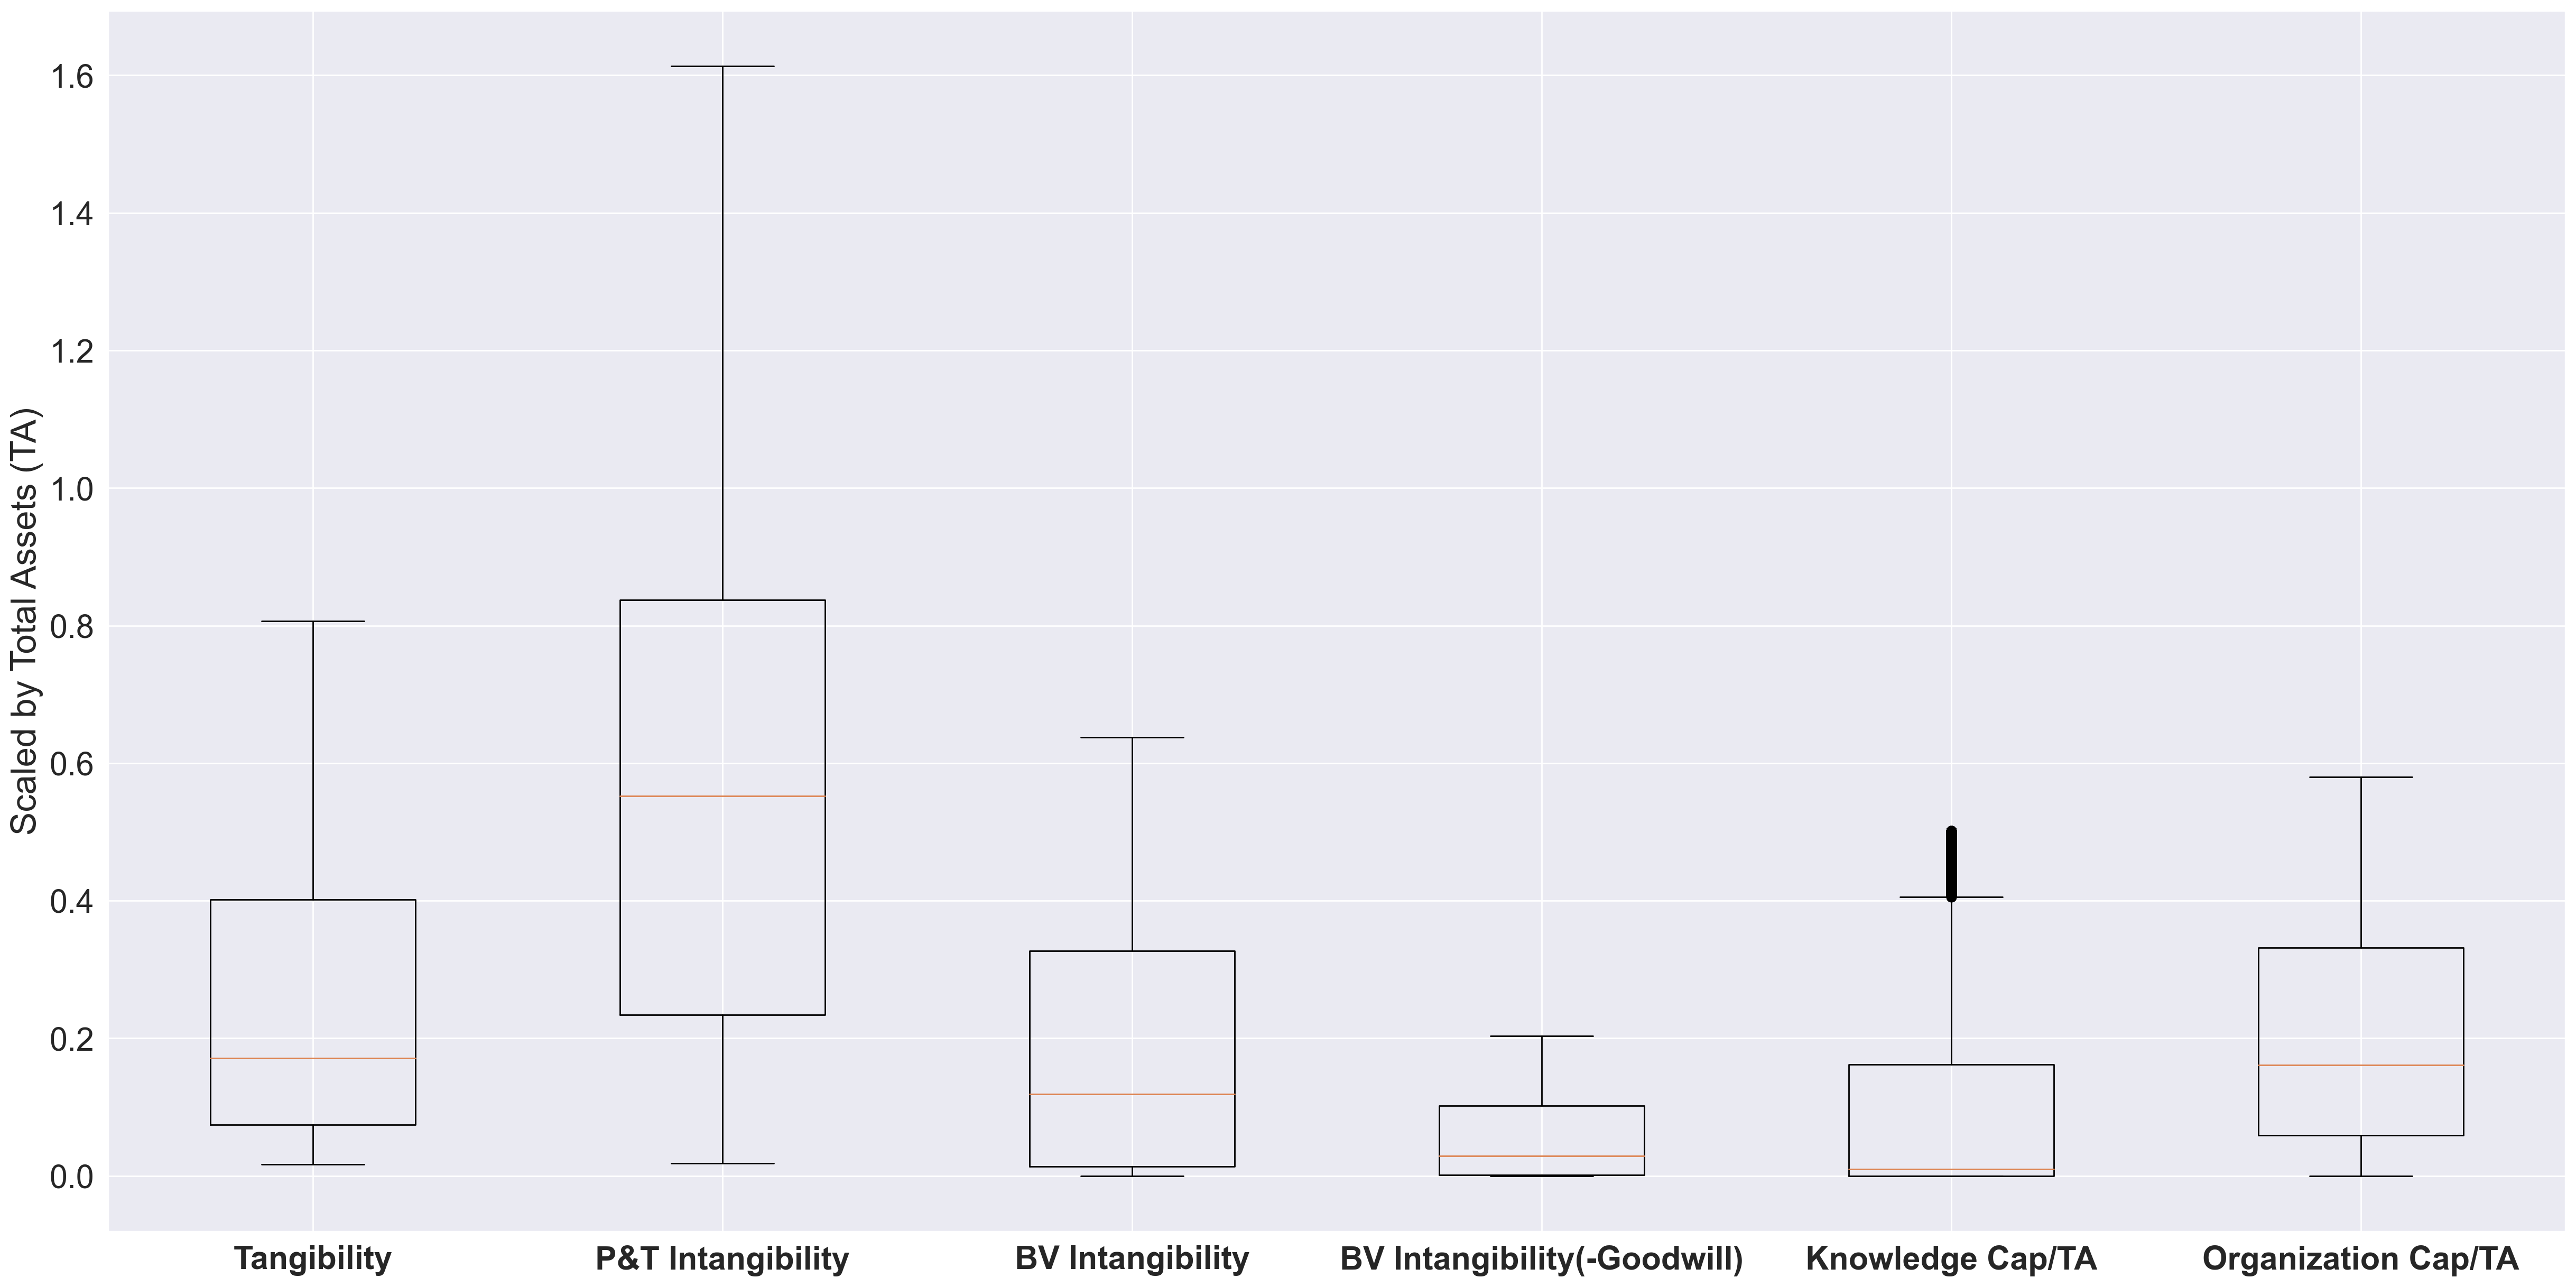

In [11]:
# boxplot of key intangible/tangible asset variables
df = reg_df_w[['PPENT_AT', 'intan_cap_AT',
               'intan_AT', 'intan_lessgdwl_AT', 
               'know_cap_AT', 'organ_cap_AT']].set_axis(['Tangibility', 'P&T Intangibility', 
               'BV Intangibility', 'BV Intangibility(-Goodwill)', 
               'Knowledge Cap/TA', 'Organization Cap/TA'],axis=1)

plt.figure(figsize=(30,15), dpi=200)
plt.boxplot(df) # violinplot boxplot
plt.xticks(list(range(1,len(df.columns)+1)), list(df.columns), rotation=0, fontweight='bold');
plt.ylabel('Scaled by Total Assets (TA)');
#plt.savefig('estimates_boxplot.png')

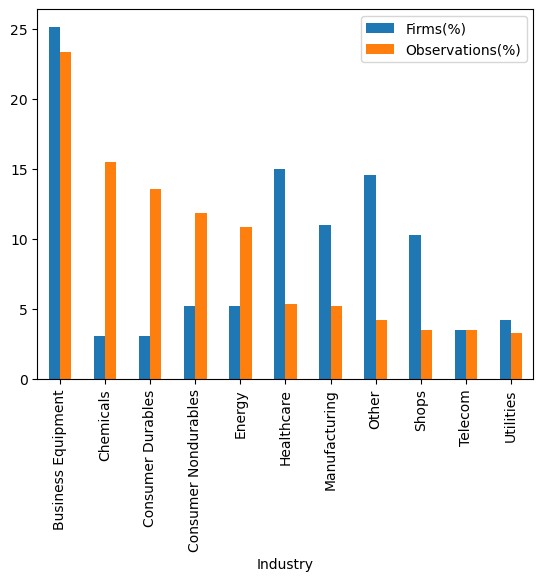

In [12]:
# observation distributions across the industries
industry_firms = reg_df_w.groupby('sic')['gvkey'].nunique()
industry_firms.index = ['Business Equipment', 'Chemicals', 'Consumer Durables', 'Consumer Nondurables',
                        'Energy', 'Healthcare', 'Manufacturing', 'Other', 'Shops', 'Telecom',
                        'Utilities']
industry_pct = round(reg_df_w.groupby('sic')['gvkey'].nunique() / reg_df_w['gvkey'].nunique() * 100, 2)
industry_pct = pd.Series(industry_pct.values, name = 'Percentage', index=None)
industry_firms = pd.DataFrame(pd.merge(industry_firms, industry_pct, on = industry_firms.index))

industry_N = reg_df_w['sic'].value_counts()
industry_N.index = ['Business Equipment', 'Chemicals', 'Consumer Durables', 'Consumer Nondurables',
                    'Energy', 'Healthcare', 'Manufacturing', 'Other', 'Shops', 'Telecom',
                    'Utilities']
industry_N_pct = round(reg_df_w['sic'].value_counts() / len(reg_df_w['sic']) * 100, 2)
industry_N = pd.DataFrame(pd.merge(industry_N, industry_N_pct, on=industry_N.index))

industry_firms = pd.merge(industry_firms, industry_N, on = 'key_0').set_axis(['Industry','Firms','Firms(%)',
                                                                              'Observations','Observations(%)'], axis=1)
industry_firms.index = industry_firms['Industry']
industry_firms = industry_firms.drop(columns = ['Industry'])

plt.style.use('default')
industry_firms[['Firms(%)', 'Observations(%)']].plot(kind='bar');

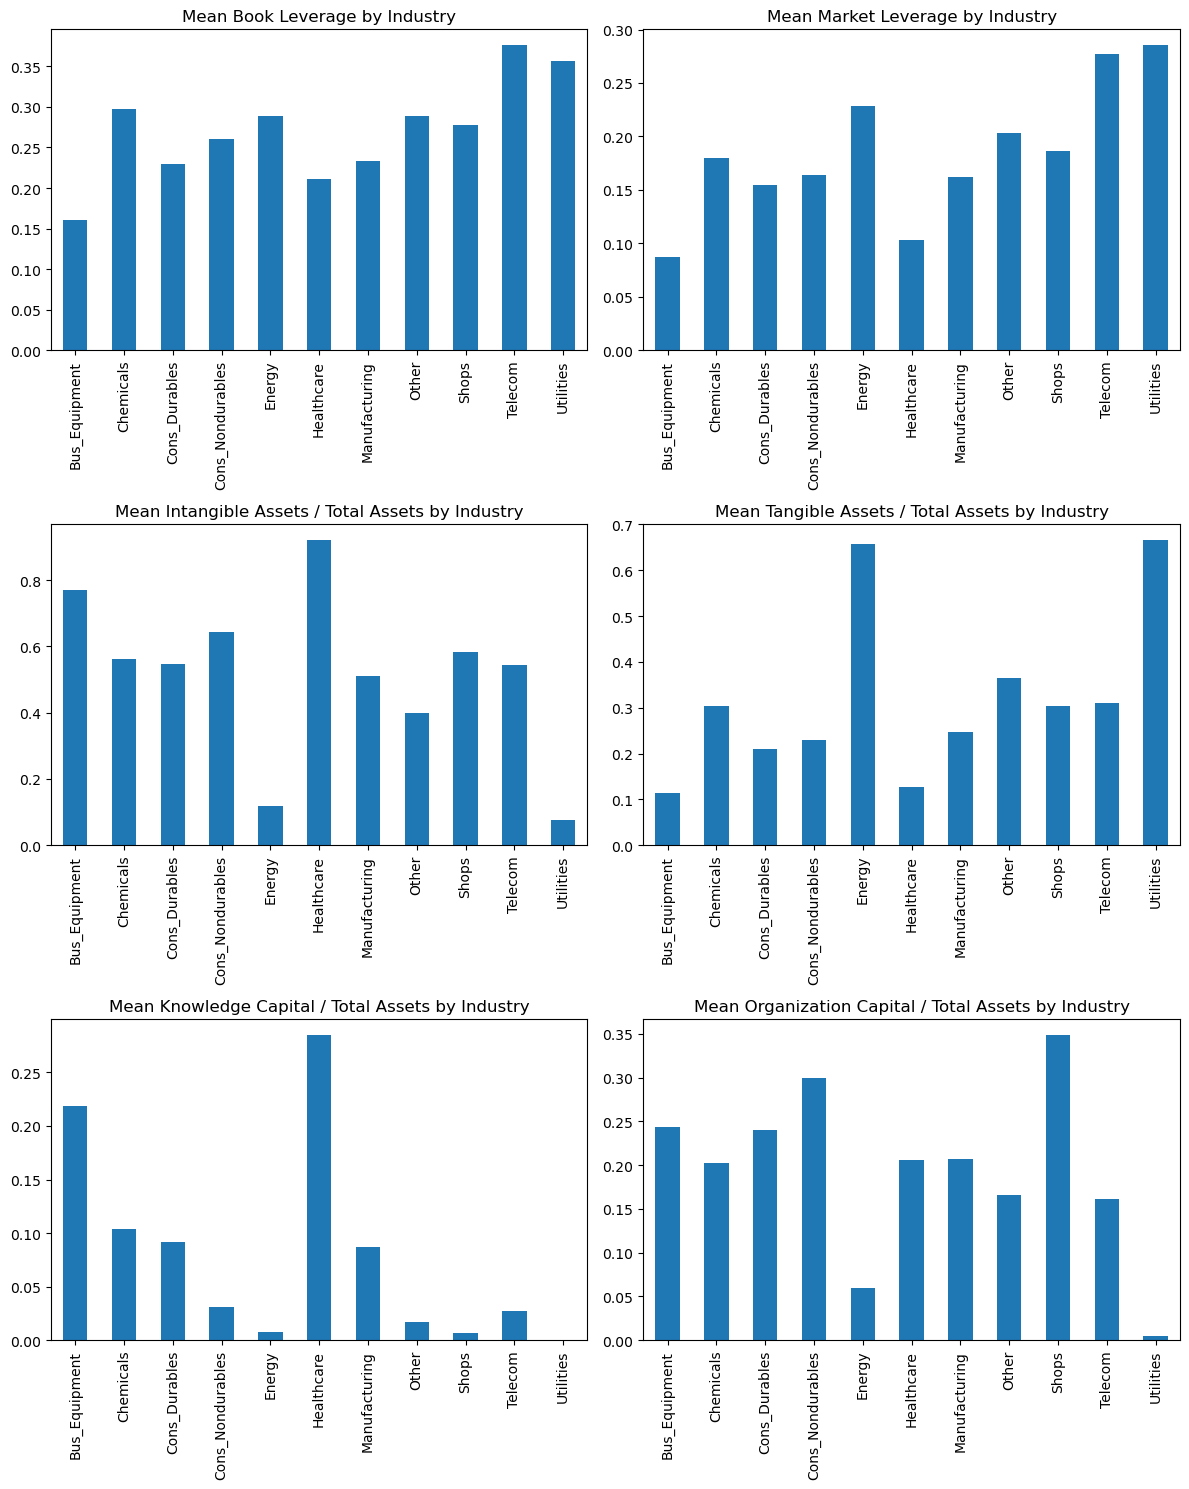

In [13]:
# Mean regression variable visualizations across the industries
importlib.reload(fyp)
plt.style.use('default')
fyp.Industry_regvar_vis(reg_df_w, w = 12,h = 15)

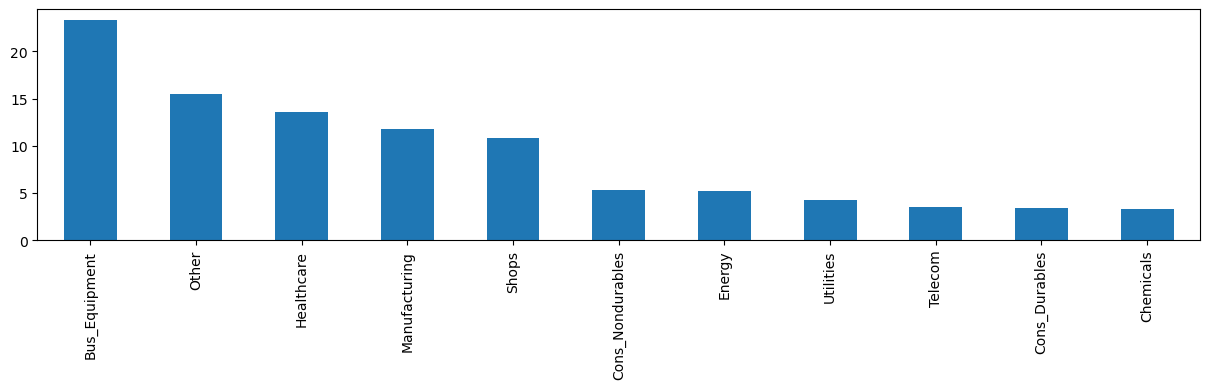

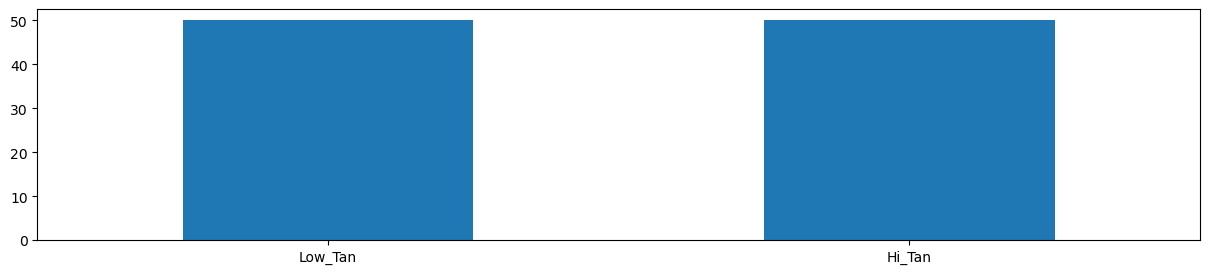

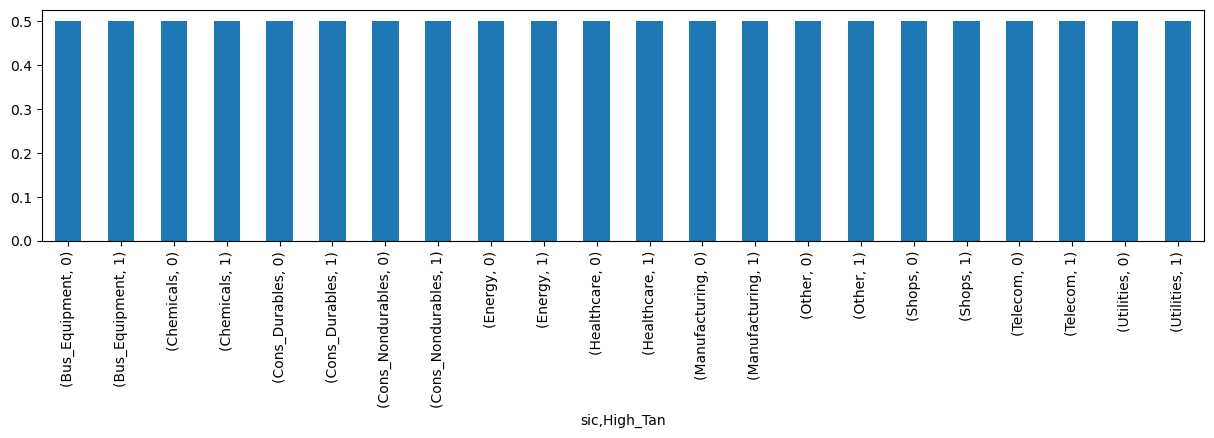

In [14]:
reg_df_w = fyp.Tangibility_dummy(reg_df_w)
reg_df_w['After2015'] = reg_df_w['fyear'] > 2014
reg_df_w['After2015'].value_counts();

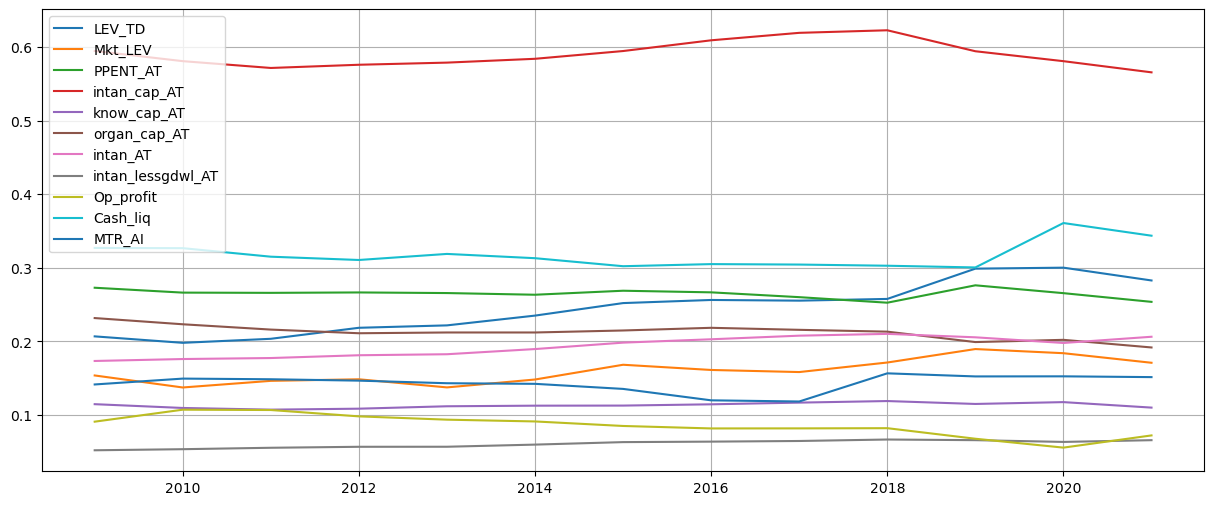

In [15]:
### Time series plot of variable means over time
df = reg_df_w[reg_vars + ['gvkey','fyear']].drop(columns=['age', 'log_asset', 'Market_to_Book']).copy()
plt.figure(figsize=(15,6))
plt.plot(df.drop(columns=['gvkey']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear']).columns);
plt.grid()
plt.legend(loc='upper left');

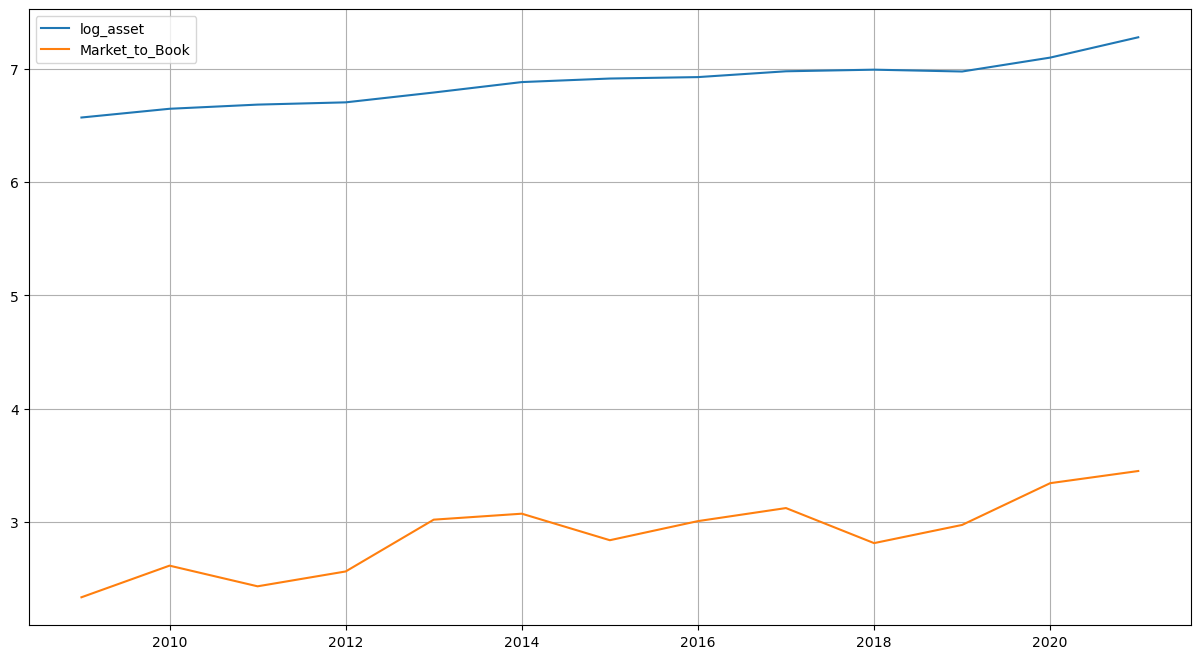

In [16]:
### Time series plot of variable means over time
df = reg_df_w[['log_asset', 'Market_to_Book'] + ['gvkey','fyear']].copy()
plt.figure(figsize=(15,8))
plt.plot(df.drop(columns=['gvkey']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear']).columns);
plt.grid()
plt.legend(loc='upper left');

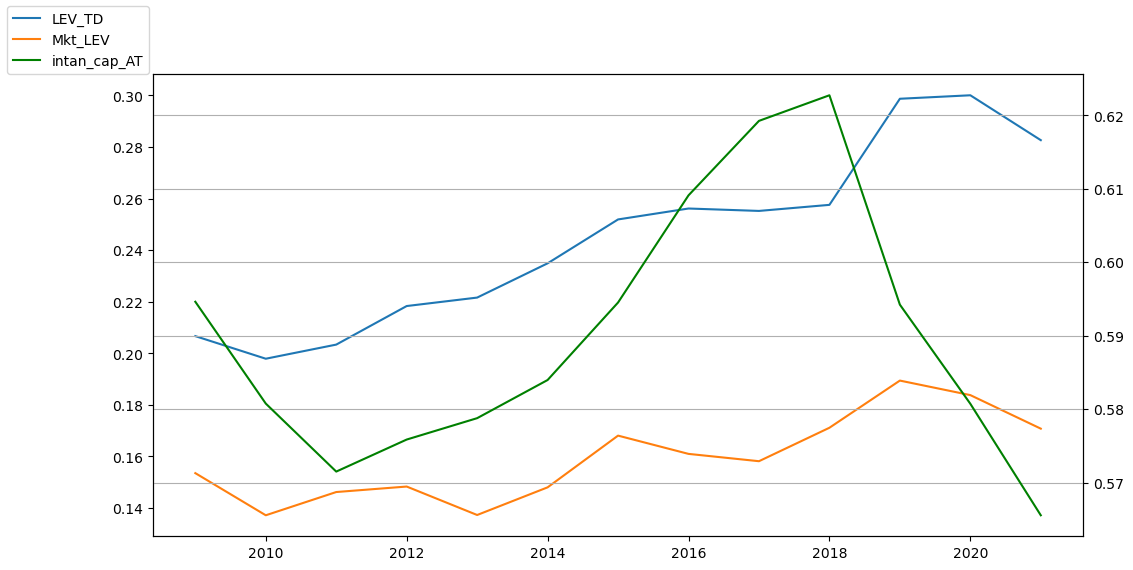

In [17]:
DV = ['LEV_TD', 'Mkt_LEV']
key_IV = ['PPENT_AT', 'intan_cap_AT', 'know_cap_AT', 'organ_cap_AT', 'intan_AT', 'intan_lessgdwl_AT']
control = ['age', 'log_asset', 'Market_to_Book', 'Op_profit', 'Cash_liq', 'MTR_AI']

### Time series plot of variable means over time
df = reg_df_w[DV + ['intan_cap_AT', 'gvkey','fyear']].drop(columns=[]).copy()
fig, ax = plt.subplots(figsize=(12,6))
ax1 = ax.twinx()
ax.plot(df.drop(columns=['gvkey','intan_cap_AT']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear','intan_cap_AT']).columns);
ax1.plot(df[['intan_cap_AT','fyear']].groupby('fyear').mean(), label='intan_cap_AT', color='green')
plt.grid()
fig.legend(loc='upper left');

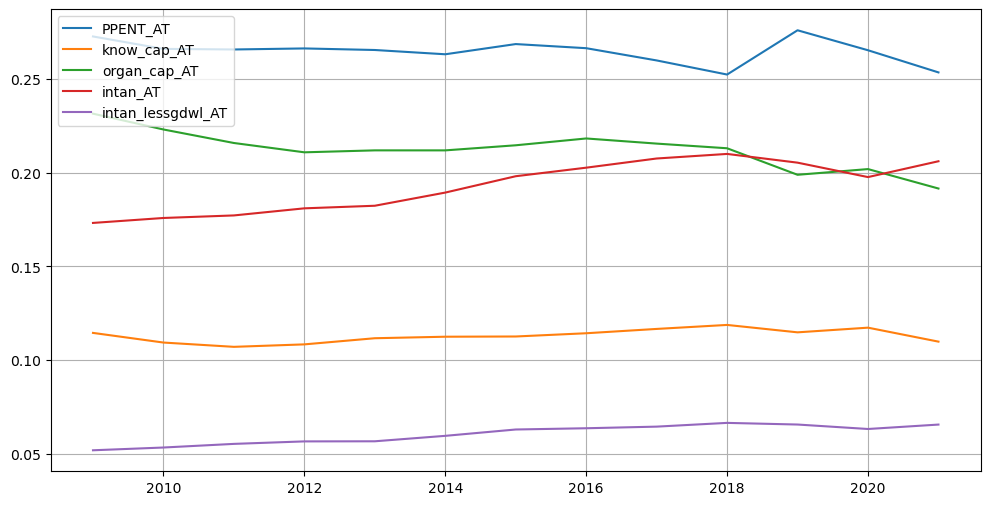

In [18]:
### Time series plot of variable means over time
df = reg_df_w[key_IV + ['gvkey','fyear']].drop(columns=['intan_cap_AT']).copy()
plt.figure(figsize=(12,6))
plt.plot(df.drop(columns=['gvkey']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear']).columns);
plt.grid()
plt.legend(loc='upper left');

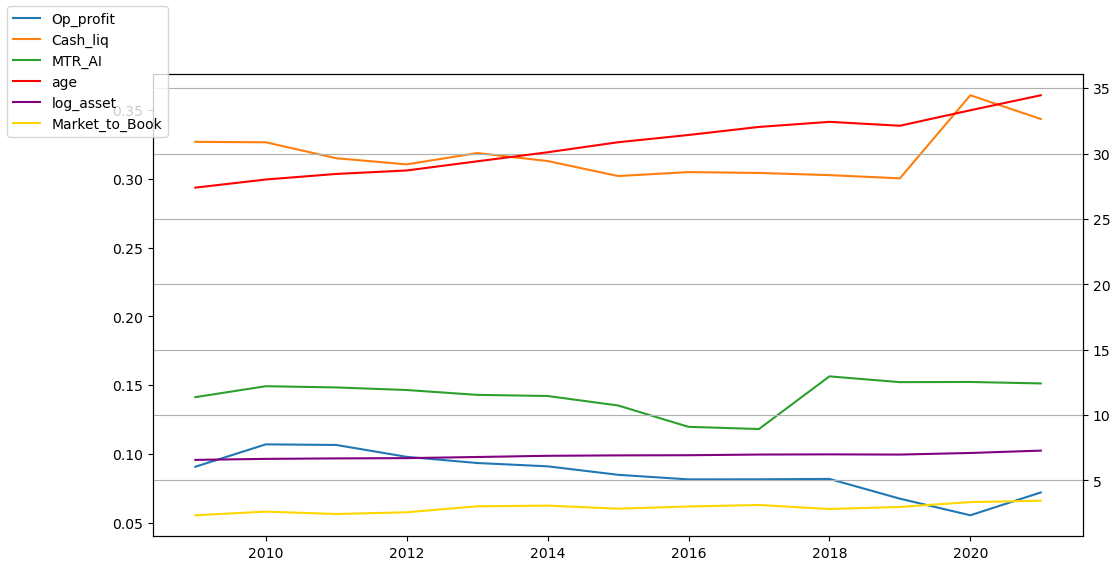

In [19]:
### Time series plot of variable means over time
df = reg_df_w[control + ['gvkey','fyear']].copy() # .drop(columns=['age','log_asset', 'Market_to_Book'])
fig, ax = plt.subplots(figsize=(12,6))
ax1 = ax.twinx()
ax.plot(df.drop(columns=['gvkey','age','log_asset', 'Market_to_Book']).groupby('fyear').mean(), label=df.drop(columns=['gvkey','fyear','age','log_asset', 'Market_to_Book']).columns);
ax1.plot(df[['fyear','age']].groupby('fyear').mean(), label='age', color='red');
ax1.plot(df[['fyear','log_asset']].groupby('fyear').mean(), label='log_asset', color='purple');
ax1.plot(df[['fyear','Market_to_Book']].groupby('fyear').mean(), label='Market_to_Book', color='gold');

plt.grid()
fig.legend(loc='upper left');

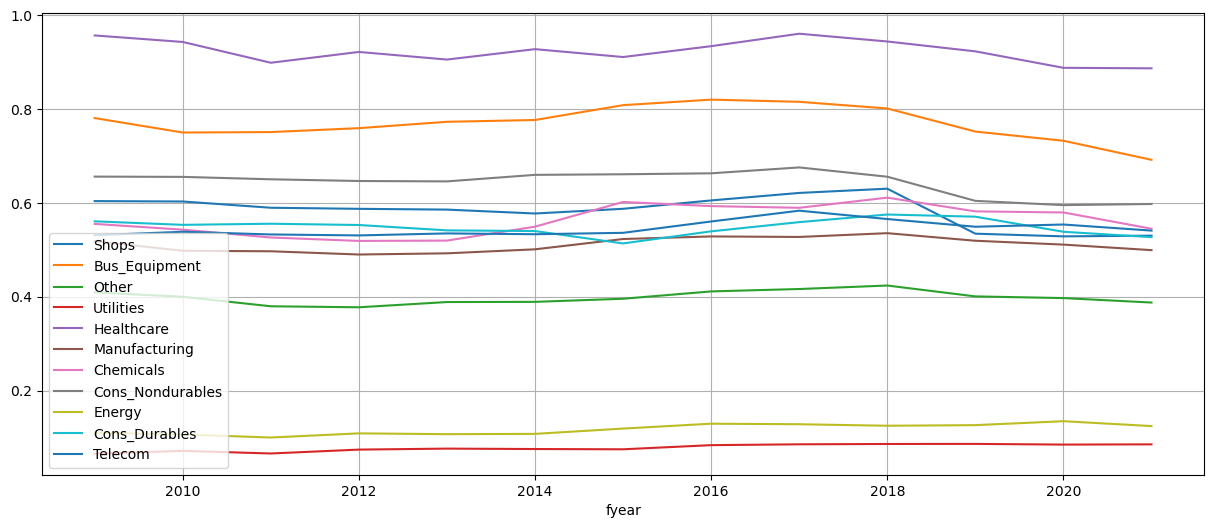

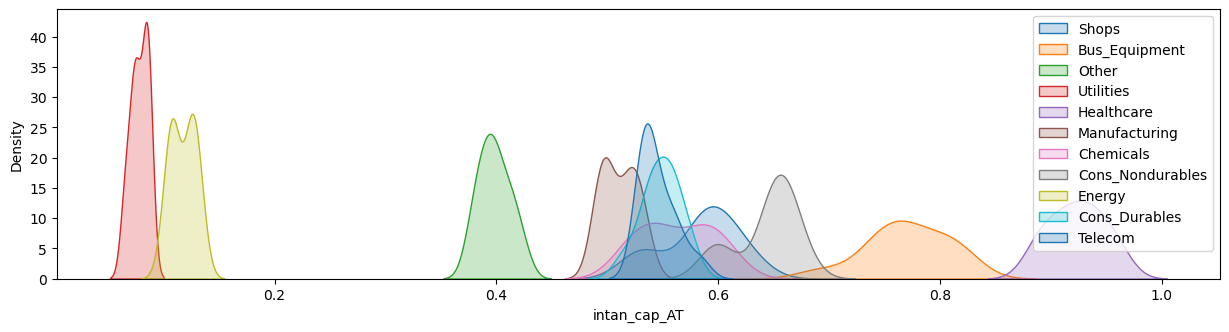

In [20]:
# industry average over time
var = 'intan_cap_AT'
plt.figure(figsize=(15,6))
for industry in list(reg_df_w['sic'].unique()):
    reg_df_w.query(f'sic == "{industry}"').groupby('fyear').mean()[var].plot(label = f'{industry}')
plt.grid()
plt.legend();

plt.figure(figsize=(15,3.5))
for industry in list(reg_df_w['sic'].unique()):
    sns.kdeplot(reg_df_w.query(f'sic == "{industry}"').groupby('fyear').mean()[var], label=f'{industry}', shade=True)
plt.legend();

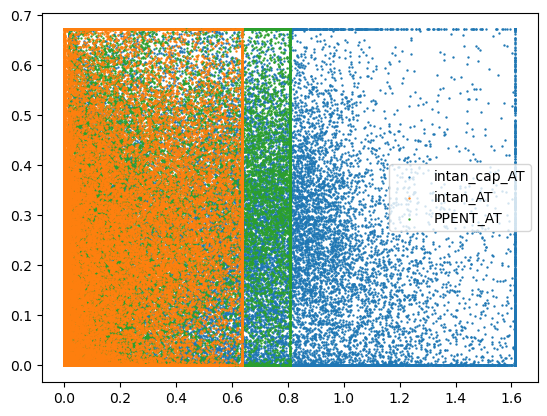

In [21]:
plt.scatter(reg_df_w['intan_cap_AT'],reg_df_w['LEV_TD'], label='intan_cap_AT', s=0.5);
plt.scatter(reg_df_w['intan_AT'],reg_df_w['LEV_TD'], label='intan_AT', zorder=2, s=0.5);
plt.scatter(reg_df_w['PPENT_AT'],reg_df_w['LEV_TD'], label='PPENT_AT', s=0.5);
plt.legend();

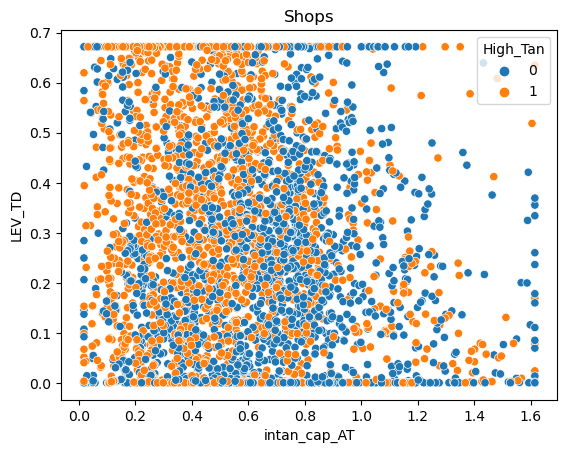

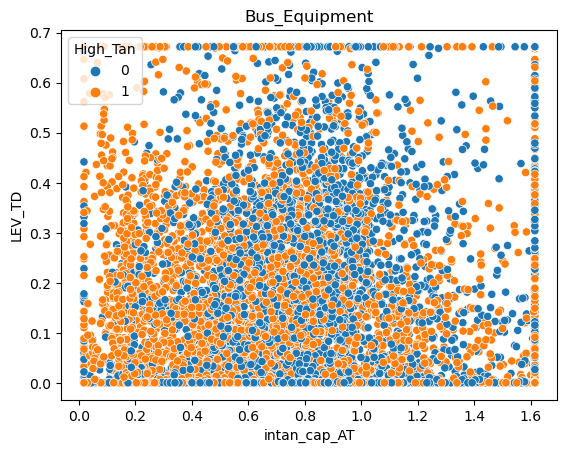

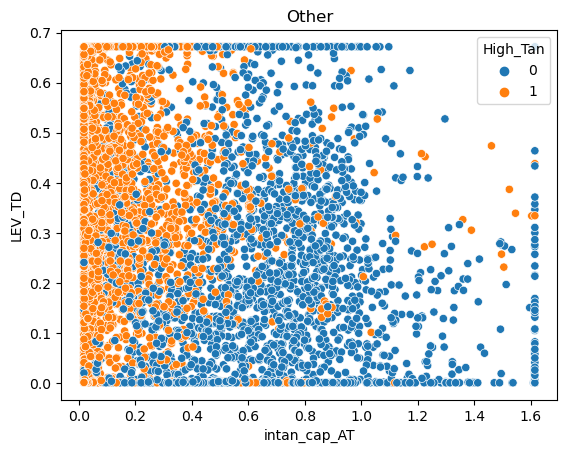

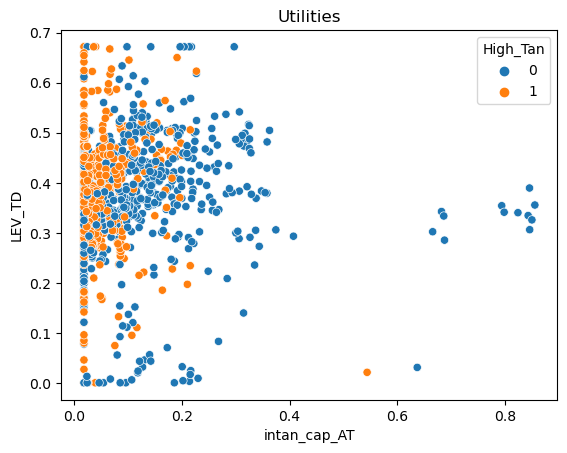

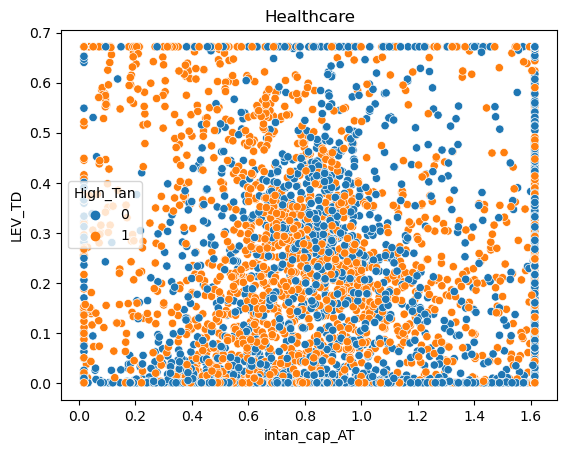

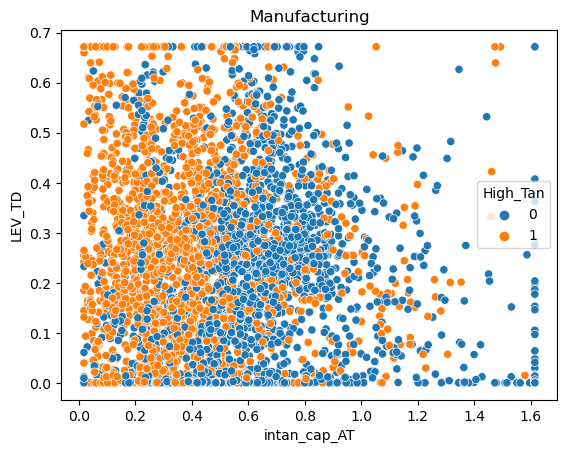

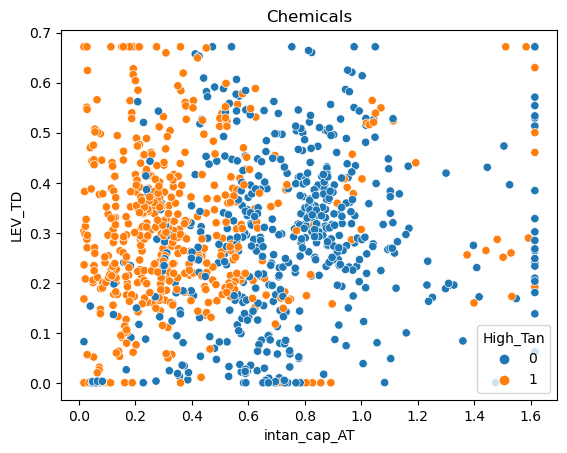

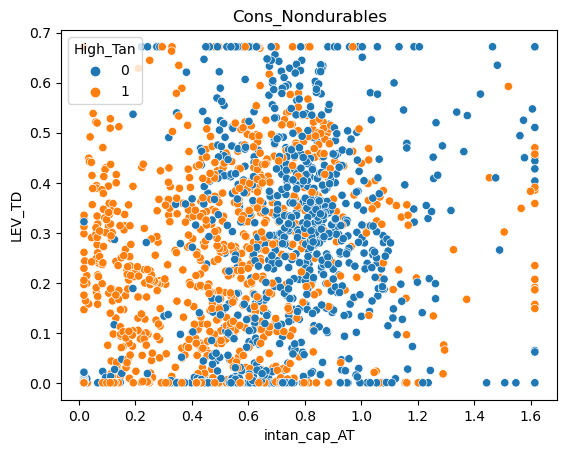

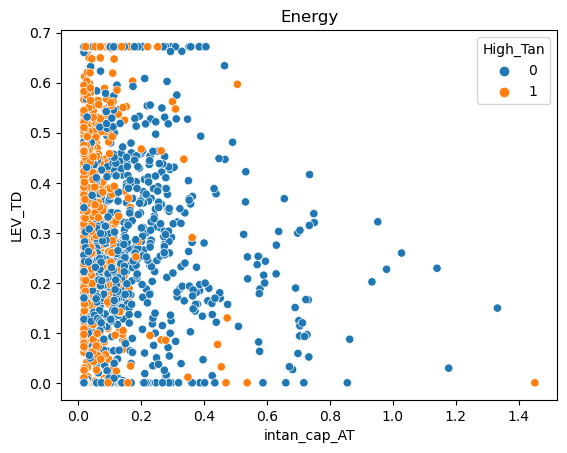

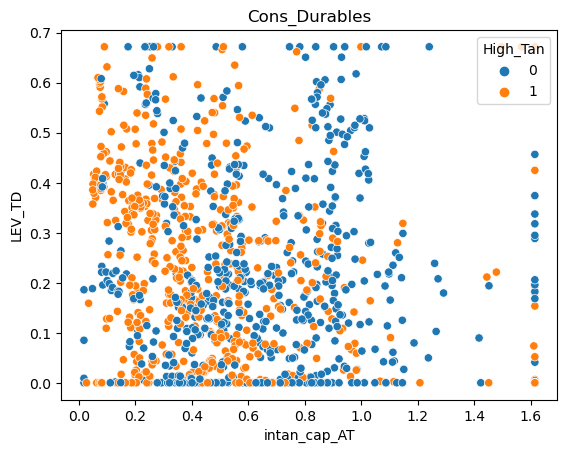

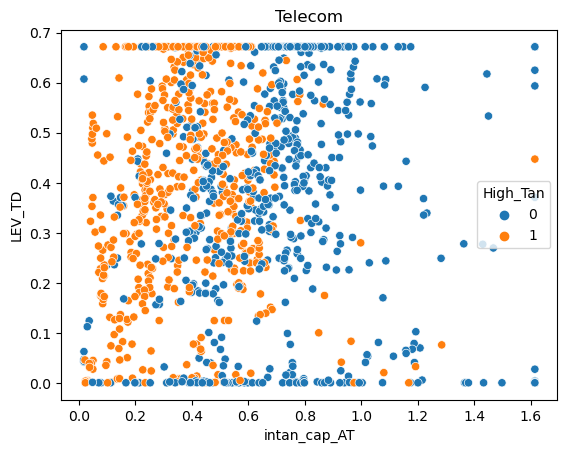

In [22]:
IV = 'intan_cap_AT'
DV = 'LEV_TD' #'Mkt_LEV'
for sector in list(reg_df_w['sic'].unique()):
    vis_df = reg_df_w[reg_df_w['sic'] == sector]
    plt.title(f'{sector}')
    sns.scatterplot(x=vis_df[IV], y=vis_df[DV], hue = vis_df['High_Tan'])
    plt.show()

In [23]:
## High_Tan varies within individuals, not time-invariant
reg_df_w.groupby('gvkey').nunique()[reg_df_w.groupby('gvkey')['High_Tan'].nunique() > 1].head()

fyear  tic  at  ceq  gdwl  intan  ppent  sale  sic  age  ...  \
gvkey                                                           ...   
1121      13    1  13   13     1      4     13    13    1   13  ...   
1161      13    1  13   13     5     13     13    13    1   13  ...   
1380      13    1  13   13     8      8     13    13    1   13  ...   
1439      13    1  13   13    13     13     13    13    1   13  ...   
1440      13    1  13   13     3      8     13    13    1   13  ...   

       Healthcare  Manufacturing  Chemicals  Cons_Nondurables  Energy  \
gvkey                                                                   
1121            1              1          1                 1       1   
1161            1              1          1                 1       1   
1380            1              1          1                 1       1   
1439            1              1          1                 1       1   
1440            1              1          1                 1       1   

       Cons_Durables  Telecom  Med_Tan  High_Tan  After2015  
gvkey                                                        
1121               1        1        1         2          2  
1161               1        1        1         2          2  
1380               1        1        1         2          2  
1439               1        1        1         2          2  
1440               1        1        1         2          2  

[5 rows x 50 columns]

In [11]:
#sns.pairplot(reg_df_w[[DV] + key_IV + control + ['High_Tan']], hue = 'High_Tan');

# Next: FYP_Regressions.ipynb
Replicated regression results on Python